In [2]:
#Install the necessary packages

#!pip install yfinance
#!pip install matplotlib==3.5.3

In [3]:
#Standard packages
import numpy as np
from math import factorial
import pandas as pd

#Dates
from datetime import datetime, timedelta

#Finance packages
import yfinance as yf

#Statistics
from scipy.stats import binom

#Plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from matplotlib import rcParams

rcParams["font.size"] = 20
rcParams["axes.labelsize"] = 30

rcParams["xtick.labelsize"] = 16
rcParams["ytick.labelsize"] = 16

rcParams["figure.figsize"] = (8,6)

A financial option is a contract between a buyer and a seller that gives the buyer the right, but not the obligation, to buy or sell an underlying asset, such as a stock, at a specific price (**strike price**, $K$) on or before a specific date (**expiration date**, $T$). The seller, or option writer, is obligated to fulfill the terms of the contract if the buyer chooses to exercise their option. Options can be used for a variety of purposes, such as hedging risk or speculating on the price movement of an asset. There are two main types of options: **call** options, which give the buyer the right to buy the underlying asset, and **put** options, which give the buyer the right to sell the underlying asset. The options are buyed at a given price, $C_0$.

There are different types of options with different obligations, but we will focus on the European ones, which can only be executed at the expiration date.

Mathematically, we can evaluate the payoff of an (european) option at the expiration date $T$ as function of the value of the underlying asset at that moment, $Y(T)$, the strike price $K$ and the initial price, $C_0$.

The payoff of a call option is the difference between the price of the underlying asset and the strike price of the option

$$P_c(Y,T) = max(Y(T) - K - C_0, -C_0)$$

The payoff of a put option is the difference between the strike price of the option and the price of the underlying asset

$$P_p(Y,T) = max(K - Y(T)-C_0, -C_0)$$

It's important to note that these payoffs are only realized if the option is exercised and the underlying asset is bought or sold at the strike price. Also, the above equations are for European Options, so for other options the payoffs can be different.

#The binomial model

The binomial option pricing model is a mathematical model that is used to determine the *fair value* of an option. It is based on the idea that the underlying asset can move to one of two possible states (up or down) at the end of each time period. The model uses a recursive algorithm to calculate the value of the option at each point in time, taking into account the probability of the underlying asset moving up or down and the resulting payoffs from the option. In this model, the fair price of the option after a time $t=N\Delta t$ (so $N$ steps) is given by

$$C_0=e^{-rt}\sum_{k=0}^N\left(\begin{array}{c}N \\
k\end{array}\right)p_e^k\left(1-p_e\right)^{N-k}max(u^kd^{N-k}Y_0-K, 0)$$

with $p_e=\frac{e^{r\Delta t}-d}{u-d}$ and $u, d$ being the factor in which the price of the option can change *up* or *down*, respectively.

Indeed, a closed equation for the *fair price* of the option after $N$ steps can be found in terms of the cumulative distribution function of the binomial distribution, $F(x; N, p)$,

$$C_0=Y_0F(N-a, N, q_e')- e^{-rt}KF(N-a, N, q_e)$$

where

* $a=\left\lceil\frac{\ln(K/Y_0d^N)}{\ln(u/d)}\right\rceil$ where $\lceil x\rceil$ is the ceil function, which returns the smallest integer $i$ such that $i\geq x$

* $q_e = 1-p_e$

* $q_e'=1-ue^{-r\Delta t}p_e$

* $F(N-a,N,q_e)$ is the cumulative distribution of the binomial

In practice, $u$ and $d$ are determined from the volatility of the underlying asset.

# Exercise 1. Option Pricing using the binomial model

1. Implement the binomial model for option pricing using the first of the formulas above

  * I give you the implementation of the second formula, the "analytical" one.

2. Compare your implementation to the analytical one by giving some values to the parameters and runing the functions.

3. Use the binomial model to price real options of BP.

  * Compare your predicted fair values of the options with the traded ones. Is there a correspondance?

4. Repeat the previous step now with options from Tesla

  * What do you observe? Why do you think this is happening?



**1. Complete the functions below to implement the binomial model for a call option.**

*Clue: use the `numpy.ceil()` method to obtain $a$*

*Clue: use the `scipy.stats.binom` function to compute the CDF of the binomiald distribution. The function is alrealy loaded as `binom`*

In [4]:
def comb(n, i):
    'Returns the result of n combined with i'
    return factorial(n) / (factorial(n-i)*factorial(i))

def call_price_binomial_computational(N, Y0, K, r, dt, u, d):
    '''
    Parameters:
    - N: Number of steps
    - Y0: Initial price (underlying asset)
    - K: Strike price (option)
    - r: Annual risk-free interest rate
    - dt: Time step size
    - u: Up factor
    - d: Down factor
    '''
    t = N*dt                                # Expiration date
    p_e = (np.exp(r * dt) - d) / (u - d)    # Probability of the asset moving up
    C0 = 0                                  # Initiate call option price

    for k in range(0, N + 1):
        A = comb(N, k) * p_e**k * (1 - p_e)**(N-k)
        C0 += A * np.maximum(Y0 * u**k * d**(N-k) - K, 0)

    C0 *= np.exp(-r * t)
    return C0

def call_price_binomial_analytical(N, Y0, K, r, dt, u, d):
    t = N*dt                                # Expiration date
    p_e = (np.exp(r * dt) - d) / (u - d)    # Probability of the asset moving up
    q_e = 1 - p_e                           # Probability of moving down
    q_e_prime = 1 - u * np.exp(-r * dt) * p_e  # Modified probab

    a = np.ceil( np.log(K / (Y0 * (d ** N))) / np.log(u / d) )

    # Use of the CDF function for cumulative probability
    cdf_prime = binom.cdf(N - a, N, q_e_prime)
    cdf = binom.cdf(N - a, N, q_e)
    # Price of the call option
    C0 = (Y0 * cdf_prime) - (np.exp(-r * t) * K * cdf)
    return C0

**2. Compare computational and theoretical methods**

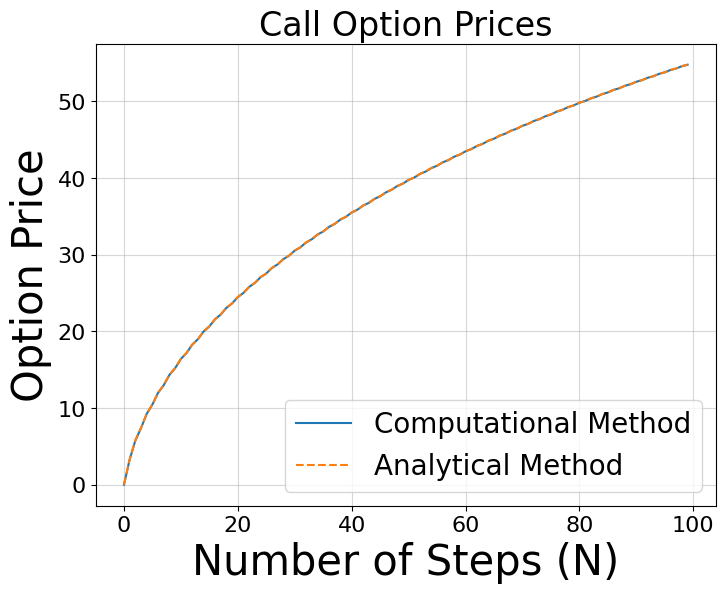

In [5]:
#Initial value of the underlying asset
Y0  = 100

#Volatility of the underlying asset
sigma = 0.5

#Strike price
K = 110

#Interest rate (zero for simplicity)
r = 0.0

#Time step
dt = 0.1

#Up and down price change factors
u = np.exp( sigma * np.sqrt(dt))
d = np.exp(-sigma * np.sqrt(dt))

#Steps
steps = 100

# Arrays to store the option prices for each step
prices_computational = []
prices_analytical = []

# Compute the fair prices for each step (N from 0 to steps) using both methods
for N in range(steps):
    price_compu = call_price_binomial_computational(N, Y0, K, r, dt, u, d)
    prices_computational.append(price_compu)

    price_analy = call_price_binomial_analytical(N, Y0, K, r, dt, u, d)
    prices_analytical.append(price_analy)

#Plot the prices according to both methods
plt.plot(range(steps), prices_computational, label='Computational Method')
plt.plot(range(steps), prices_analytical,    label='Analytical Method', linestyle='--')
plt.xlabel('Number of Steps (N)')
plt.ylabel('Option Price')
plt.title('Call Option Prices')
plt.legend()
plt.grid(alpha = 0.5)

**3. Price Real Options from BP**

Run the following cell to download the data.

**It will take a while to download, be patient.**

Then, price each **Call** option using the binomial model and compare the results with the real traded prices.

**Note that we download data for Call and Put options, but we only want to price the Call ones**

In [6]:
def options_data(symbol):

    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        # opt = pd.DataFrame().append(opt.calls).append(opt.puts) ## deprecated
        opt = pd.concat((opt.calls, opt.puts))
        opt['expirationDate'] = e
        # options = options.append(opt, ignore_index=True) ## deprecated
        options = pd.concat((options,opt), ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    options['expirationDate'] = pd.to_datetime(options['expirationDate']) + timedelta(days = 1)
    options['dte'] = (options['expirationDate'] - datetime.today()).dt.days / 365

    # Boolean column if the option is a CALL
    options['CALL'] = options['contractSymbol'].str[4:].apply(
        lambda x: "C" in x)

    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)

    # Drop unnecessary and meaningless columns
    #options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'bid', 'ask', 'inT'])
    options = options[["lastTradeDate", "strike", "lastPrice", "expirationDate", "impliedVolatility", "openInterest", "CALL"]]

    #Add underlying price of asset for each tradeDate
    print("Matching last traded dates with underlying prices... this might take a while...")

    underlying_prices = []

    tot = len(options)

    i = 0

    for date in options["lastTradeDate"]:

      pct = 100*i/tot

      if np.round((pct % 2), 2) == 0.0:

        print("Completed: %.2f %%" % pct)

      Y0 = yf.download(asset, start=date, end=date, progress=False, period="1d")["Adj Close"].values

      if len(Y0) == 0:

        underlying_prices.append(np.nan)

      else:

        underlying_prices.append(Y0[0])

      i += 1

    options["underlying_price"] = underlying_prices

    return options

asset = "BP"

df = options_data(asset)

df = df.dropna()

df["lastTradeDate"] = pd.to_datetime(df["lastTradeDate"])
df["expirationDate"] = pd.to_datetime(df["expirationDate"])

df

Matching last traded dates with underlying prices... this might take a while...
Completed: 0.00 %
Completed: 50.00 %


,lastTradeDate,strike,lastPrice,expirationDate,impliedVolatility,openInterest,CALL,underlying_price
0,2024-05-28 14:16:22+00:00,28.0,9.20,2024-06-01,0.000010,4,True,37.400002
1,2024-05-23 16:35:34+00:00,30.0,6.74,2024-06-01,0.000010,1,True,36.419998
2,2024-05-16 17:06:14+00:00,32.5,4.65,2024-06-01,0.000010,2,True,37.110001
3,2024-05-24 17:42:36+00:00,34.5,2.27,2024-06-01,0.000010,20,True,36.720001
4,2024-05-28 19:54:49+00:00,35.0,2.49,2024-06-01,0.000010,39,True,37.400002
...,...,...,...,...,...,...,...,...
509,2024-05-07 15:39:44+00:00,45.0,8.67,2026-01-17,0.000010,2054,False,37.146080
510,2024-03-22 16:44:45+00:00,47.0,10.30,2026-01-17,0.132821,2201,False,37.363537
511,2024-04-25 16:54:23+00:00,50.0,11.41,2026-01-17,0.239265,681,False,39.162521
512,2024-05-13 14:12:33+00:00,55.0,17.30,2026-01-17,0.000010,0,False,37.660072


In [7]:
# Log Returns
def LogRet(asset):
    df = yf.download(asset, period = "2y", interval = "1d", progress=False, ignore_tz=True)["Adj Close"]
    return np.log(1+df.pct_change()).dropna()
# Calculate sigma
sigma = np.std(LogRet(asset))

# Parameters
r = 0.0     # Interest rate
dt = 0.1    # Time step
u = np.exp( sigma * np.sqrt(dt)) # Up & down factors
d = np.exp(-sigma * np.sqrt(dt))

# Filter for Call options
df_calls = df[df['CALL']].copy()

def compute_call_prices_df(r, dt, u, d, df_calls):
    'Updates DataFrame with the computed call prices, price differences, and percentage errors'
    # Correct timelike datatype
    df_calls["lastTradeDate"] = df_calls["lastTradeDate"].dt.tz_localize(None)
    # Extract data
    Ns = (df_calls["expirationDate"] - df_calls["lastTradeDate"]).dt.days
    Y0s = df_calls["underlying_price"].values
    Ks = df_calls["strike"].values
    # Traded prices of the call options
    Real_prices = df_calls["lastPrice"].values

    # Compute call prices (binomial model)
    call_prices = [
        call_price_binomial_computational(N, Y0, K, r, dt, u, d)
        for N, Y0, K in zip(Ns, Y0s, Ks)
    ]
    df_calls['computed_price'] = call_prices
    # Compare computed & real prices
    df_calls['price_difference'] = df_calls['computed_price'] - df_calls['lastPrice']
    df_calls['percentage_error'] = abs( df_calls['price_difference'] / df_calls['lastPrice'] ) * 100

    return df_calls

df_calls = compute_call_prices_df(r, dt, u, d, df_calls)

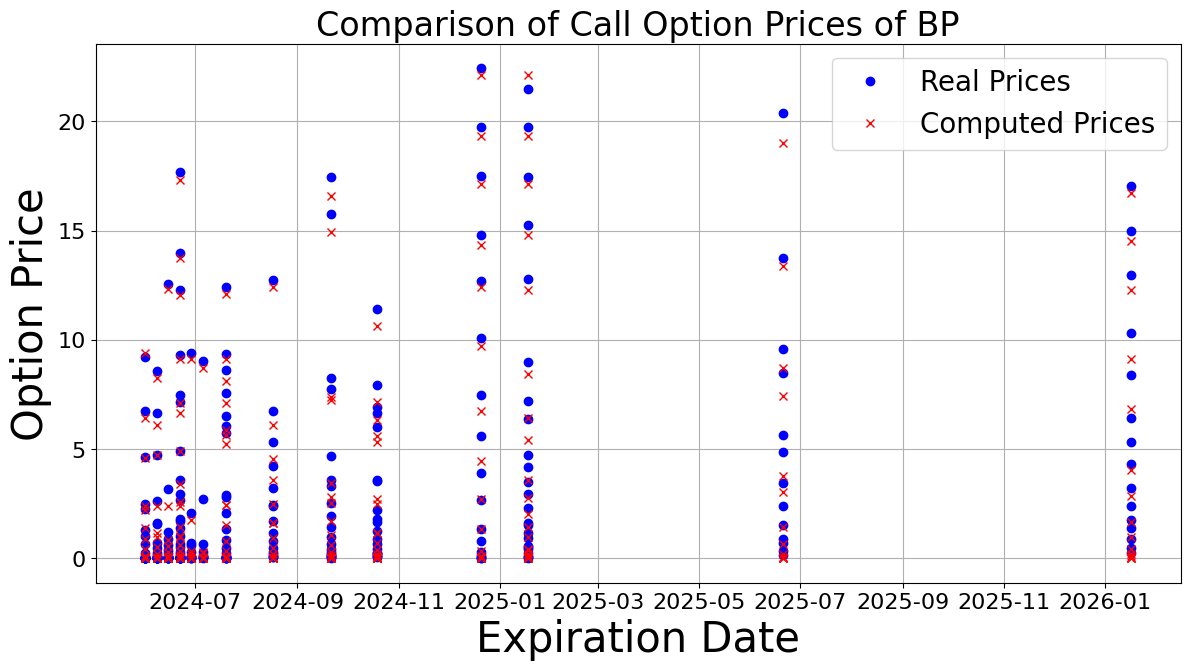

In [8]:
def plot_comparison(df_calls, asset):
    'Plot the results'

    plt.figure(figsize=(14, 7))
    plt.plot(df_calls['expirationDate'], df_calls['lastPrice'], 'o', label='Real Prices', color='blue')
    plt.plot(df_calls['expirationDate'], df_calls['computed_price'], 'x', label='Computed Prices', color='red')
    plt.xlabel('Expiration Date')
    plt.ylabel('Option Price')
    plt.title(f'Comparison of Call Option Prices of {asset}')
    plt.legend()
    plt.grid(True)

plot_comparison(df_calls, asset)

Estos resultados parecen satisfactorios, ya que la diferencia entre los precios reales y los calculados computacionalmente no difieren significativamente.

**4. Repeat the last step for options from Tesla**

*Note: Downloading these options is quite slow, as we have to match the original value of the asset for each traded date in our dataset and Tesla has many options being traded. Anyway, I did this for you so that you just need to load a CSV file*

In [9]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/Options_TSLA.csv'
df = pd.read_csv(file_path)


df = df.drop("Unnamed: 0", axis=1)
df = df.dropna()

df["lastTradeDate"] = pd.to_datetime(df["lastTradeDate"])
df["expirationDate"] = pd.to_datetime(df["expirationDate"])

Mounted at /content/drive


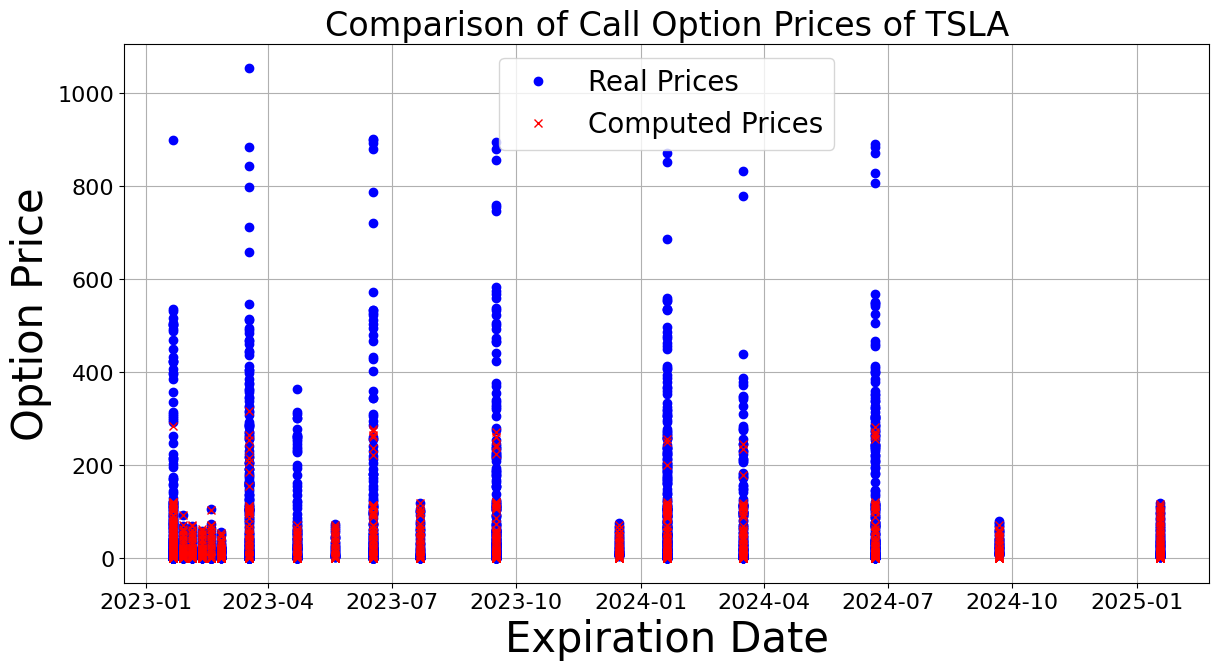

In [10]:
asset2 = 'TSLA'

# Calculate sigma
sigma = np.std(LogRet(asset2))

# Parameters
r = 0.0     # Interest rate
dt = 0.1    # Time step
u = np.exp( sigma * np.sqrt(dt)) # Up & down factors
d = np.exp(-sigma * np.sqrt(dt))

# Updates DataFrame with the computed call prices & price differences
df_calls2 = compute_call_prices_df(r, dt, u, d, df[df['CALL']].copy())
# Plot the results
plot_comparison(df_calls2, asset2)

En el caso de Tesla, los precios reales son, de media, muy superiores a los calculados computacionalmente mediante el método binomial.

He revisado el codigo y no he encontrado ningún error posible. Todo apunta a que esta disonancia se deba a la volatilidad. Dado que esta compañia es muy volatil y que el modelo binomial asume una volatilidad constante, resulta en un modelo de predicción bastante malo para el precio de estas opciones.

# Exercise 2. Implement the Black-Scholes model

The Black-Scholes model is a mathematical model used to determine the fair value of a European call option. The model was first published in 1973 by Fischer Black and Myron Scholes. The model makes several assumptions about the market, such as that the underlying asset follows a lognormal distribution, the options are European, and markets are frictionless.

The value of a call option is calculated using the following formula:

$$ C(t, T) = Y(t)\mathcal{N}(d_1) - Ke^{-r(T-t)}\mathcal{N}(d_2) $$

Where:

* $C$ is the value of the call option
* $Y(t)$ is the current price of the underlying asset
* $K$ is the strike price of the option
* $r$ is the risk-free interest rate
* $T$ is the time to expiration in years
* $\sigma$ is the volatility of the underlying asset
* $\mathcal{N}(x)$ is the cumulative probability density function of the standard normal distribution
* $d_1, d_2$ are defined as:

$$ d_1 = \frac{ln(\frac{Y(t)}{K}) + (r + \frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}} $$

$$ d_2 = d_1 - \sigma\sqrt{T-t} $$

It's important to note that the Black-Scholes model makes certain assumptions about the market, such as the underlying asset follows a lognormal distribution and the options are European and markets are frictionless, so the results may not be accurate for all situations.

**1. Implement the Black-Scholes model**

In [11]:
from scipy.stats import norm

def black_scholes(t, S, K, T, r, sigma):

    d1 = (np.log(S/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)

    call_value = S*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)

    return call_value

**2. Compute the price of an option with the given parameters using the Black-Scholes model and the binomial model (with both analytical and computational methods)**

 * I already give you this done

 * Plot the results for the values at different times. What do you observe?

<ipython-input-11-7fffc88de699>:5: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))


Text(0.5, 1.0, 'Comparison of Call Methods')

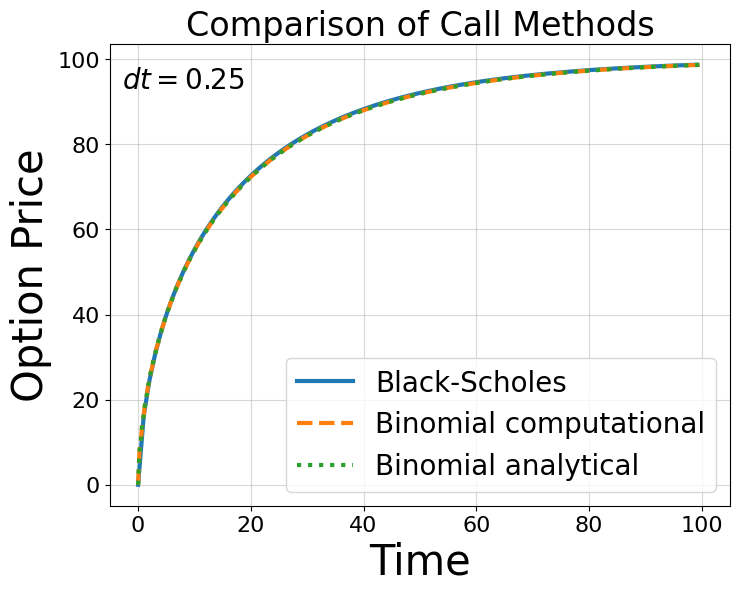

In [42]:
S = 100 #price of the underlying asset
K = 110 #strike price of the option
T = 100 #time to expiration
r = 0.0 #risk-free interest rate
sigma = 0.5 #volatility of the underlying asset
t = 0

#Time step
dt = 0.25

def method_comparison(dt, ax):
    # Parameters that depend on dt
    u = np.exp( sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    steps = int(T/dt)

    #Compute the fair prices for each step (N from 0 to steps) using the computational and analytical methods
    C0_binom_comp = [call_price_binomial_computational(N, Y0, K, r, dt, u, d) for N in range(0, steps)]
    C0_binom_anal = [call_price_binomial_analytical(N, Y0, K, r, dt, u, d) for N in range(0, steps)]
    C0_BS         = [black_scholes(t, S, K, T, r, sigma) for t in np.linspace(T, 0, 100)]

    #Plotting
    ax.text(0.02, 0.95, f'$dt = {dt}$', ha='left', va='top', transform=ax.transAxes)

    time_binom = np.linspace(0, T, steps)
    ax.plot(C0_BS, lw=3, label="Black-Scholes")
    ax.plot(time_binom, C0_binom_comp, lw=3, label="Binomial computational", linestyle='--')
    ax.plot(time_binom, C0_binom_anal, lw=3, label="Binomial analytical", linestyle=':')

    ax.grid(alpha = 0.5)

fig, ax = plt.subplots(1, 1)
method_comparison(dt, ax)
plt.xlabel("Time")
plt.ylabel("Option Price")
plt.legend()
plt.title("Comparison of Call Methods")

**3. Repeat the previous step decreasing the time-step. Plot it for 4 different time steps, each one smaller than the previous one.**

  * What do you observe?

<ipython-input-11-7fffc88de699>:5: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))


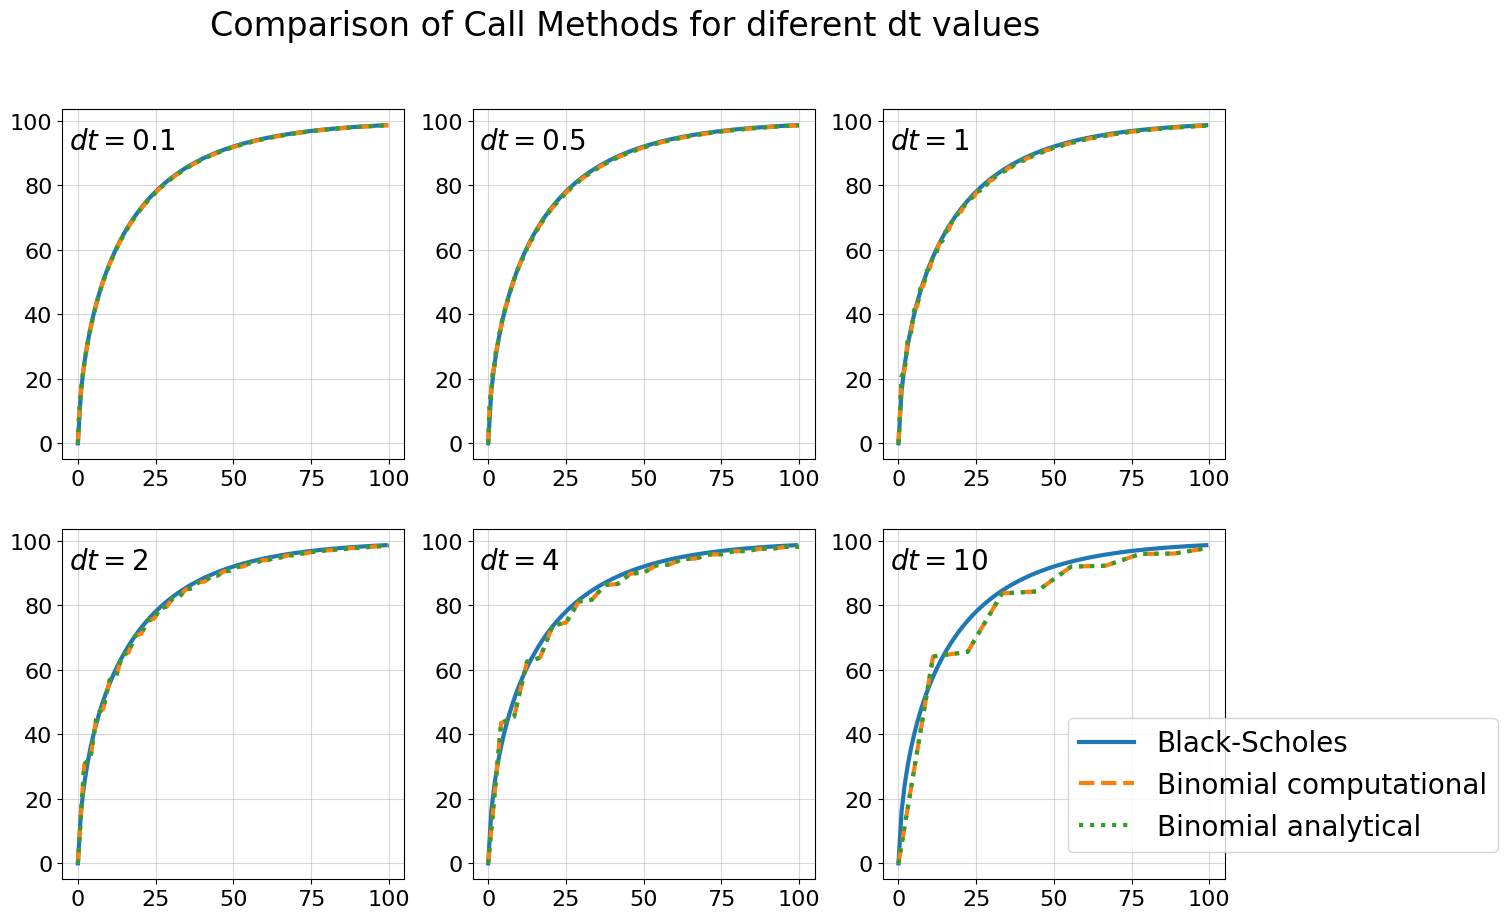

In [47]:
# We keep S, K, T, R, sigma & t parameters as before
# But we change the time step (dt)
S = 100 #price of the underlying asset
K = 110 #strike price of the option
T = 100 #time to expiration
r = 0.0 #risk-free interest rate
sigma = 0.5 #volatility of the underlying asset
t = 0

# Define different dt values
dt_values = [0.1, 0.5, 1, 2, 4, 10] # 0.25

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot each dt on a different subplot
for dt, ax in zip(dt_values, axs.ravel()):
    method_comparison(dt, ax)

plt.suptitle("Comparison of Call Methods for diferent dt values")
plt.legend(bbox_to_anchor=(0.5, 0.5))
plt.show()

# dt = 0.05 results in OverflowError: integer division result too large for a float ( comb(n, i) )

Dado que $dt = 0.05$ resulta en un error de Overflow, he decidido por usar los siguientes valores de dt, $dt=(0.1, 0.5, 1, 2, 4, 10)$. Los valores cercanos a $dt=0.25$ (los 2 primeros), muestran una buena concordancia entre los metodos binomiales y Black-Scholes. A partir del paso temporal unitario, empezamos a ver una disonancia que aumenta conforme el paso temporal aumenta. Dicho esto, podemos ver que los valores al rededor de $dt = 0.5$ dan buenos resultados para los valores obtenidos con los metodos binomiales. A la hora de usar pasos de tiempo más grandes, conviene usar Black-Scholes, esto lo hace un método más eficiente.